Flow speed:   0.52 [mm/s]
Constant 1:   2.075
Constant 2:   0.259

Matrix A is strictly diagonally dominant,therefore iterative method will converge!

Solution algorithm has been started:
150 steps has been finished ... 2850 steps remain.
300 steps has been finished ... 2700 steps remain.
450 steps has been finished ... 2550 steps remain.
600 steps has been finished ... 2400 steps remain.
750 steps has been finished ... 2250 steps remain.
900 steps has been finished ... 2100 steps remain.
1050 steps has been finished ... 1950 steps remain.
1200 steps has been finished ... 1800 steps remain.
1350 steps has been finished ... 1650 steps remain.
1500 steps has been finished ... 1500 steps remain.
1650 steps has been finished ... 1350 steps remain.
1800 steps has been finished ... 1200 steps remain.
1950 steps has been finished ... 1050 steps remain.
2100 steps has been finished ... 900 steps remain.
2250 steps has been finished ... 750 steps remain.
2400 steps has been finished ... 600 ste

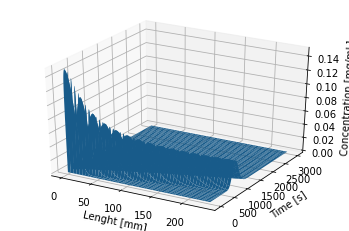

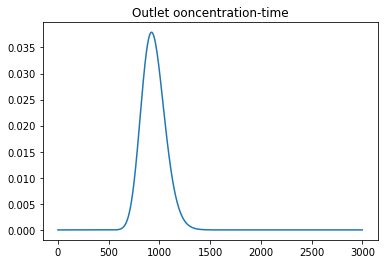

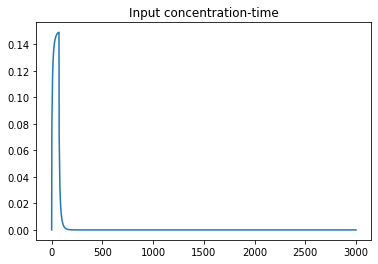

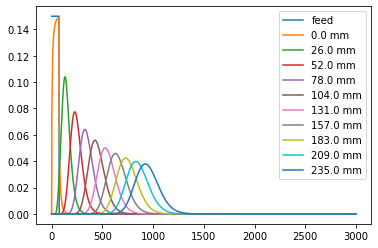

In [ ]:
# ***Numerical solution of Equilibrium Dispersive Model of Chromatography***
# ***Cranck-Nicolson Implicid Method***
# Developed by Ing. Tomas Svoboda
# University of Chemistry and Technology in Prague, Czech Republic
# Department of Carbohydrates and Cereals
# tomas3.svoboda@vscht.cz 
'''
This script implements Cranck-Nicolson implicit method for numerical solution of
second order convection-diffusion PDE used to describe concentration wave
propagation trough the chromatographic column. Numerical scheme utilizes
averaged centred difference scheme in spatial direction and forward difference
scheme in time direction. Danckwert's boudaries are implemented with usage of
fictious point for left boundary. The solution of linear algebraic system for
each time step is done by scipy.lialg.solve_banded which significatly boosts
speed.
'''

import math
import numpy as np
from scipy import linalg
from IPython.display import display
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D  
import matplotlib.pyplot as plt

#________________________________________________________________________
# DEFINING CONSTANTS

# Volume flowrate in [mL/h]
flowRate = 150
# Lenght of the packed section in the column [mm]
length = 235 
# Column diameter [mm]
diameter = 16
# Feed injection volume [mL]
feedVol = 3

# Calculation of the feed time [s]
feedTime = (feedVol/flowRate)*3600

# Concentration of the balanced component in the feed [g/mL] or [mg/mm^3]  
feedConc = 150e-3
# Total porosity of the sorbent packing [-]
porosity = 0.4
# Henry's constant of the linear isotherm [-]
henryConst = 0.9
# Axial dispersion coefficient [mm^2/s]
disperCoef = 2

# Calculation of the flow speed [mm/s]
flowSpeed = (flowRate*1000/3600)/(math.pi*((diameter/2)**2)*porosity)
print('Flow speed:   ' + str(round(flowSpeed,2)) + ' [mm/s]')

# Defining constants
C1 = (1/disperCoef)+((1+porosity)*henryConst/(porosity*disperCoef))
C2 = flowSpeed/disperCoef
print('Constant 1:   ' + str(round(C1,4)))
print('Constant 2:   ' + str(round(C2,4)) + '\n')

#________________________________________________________________________
# DATA STRUCTURES PREPARATION

time = 3000 # Finite time of the experiment [s] 
Nx = 3000 # Number of spatial differences
Nt = 3000 # Number of time differences
x = np.linspace(0, length, Nx) # Preparation of space vector
dx = length/Nx # Calculating space step [mm]
t = np.linspace(0, time, Nt) # Preparation of time vector
dt = time/Nt # Calculating time step [mm]

# Feed preparation
feedSteps = feedTime//dt # Whole number of feed iterations
feedTimeAprox = feedTime%dt # aproximation of division
# Rounding iteration step based on defined feed parameters
if feedTimeAprox >= 0.5:
  feedSteps += 1
# Constructing pulse injection feed vector
feed = np.linspace(0, time, Nt)
for i in range(0,Nt):
  if i <= feedSteps:
    feed[i] = feedConc
  else:
    feed[i] = 0

# Preparation of the solution matrix
c = np.zeros((len(t),len(x)))

#__________________________________________________________________________

def diagonal_form(a, lower= 1, upper = 1):
  # Transforms banded matrix into diagonal ordered form
  # allows to use scipy.linalg.solve_banded
  n = a.shape[1]
  assert(np.all(a.shape ==(n,n)))   
  ab = np.zeros((2*n-1, n))   
  for i in range(n):
      ab[i,(n-1)-i:] = np.diagonal(a,(n-1)-i)        
  for i in range(n-1): 
      ab[(2*n-2)-i,:i+1] = np.diagonal(a,i-(n-1))
  mid_row_inx = int(ab.shape[0]/2)
  upper_rows = [mid_row_inx - i for i in range(1, upper+1)]
  upper_rows.reverse()
  upper_rows.append(mid_row_inx)
  lower_rows = [mid_row_inx + i for i in range(1, lower+1)]
  keep_rows = upper_rows+lower_rows
  ab = ab[keep_rows,:]
  return ab

#________________________________________________________________________
# NUMERICAL SOLUTION

C_0 = np.zeros(len(x)) # Implementing initial conditions
c[0,:] = C_0
c_fict = 0 # Initial fictious point

# Crank-Nicolson matrixes preparation
# A.c(t+1) = B.c(t)x, where c(t+1) and c(t) are vectors of c(x) values
# Preparation of boudaries in matrix A
A = np.zeros((Nx,Nx)) # A matrix data structure
A[0,0] = ((2/(dx**2))+(C1/dt))/(-(1/(dx**2))-(C2/(2*dx))) # Left boundary
A[0,1] = 1-(((1/(dx**2))-(C2/(2*dx)))/(-(1/(dx**2))-(C2/(2*dx))))  # Left boundary
A[Nx-1,Nx-2] = (((1/(dx**2))+(C2/(2*dx)))/(-(1/(dx**2))+(C2/(2*dx)))) - 1 # Right boundary
A[Nx-1,Nx-1] = -((2/(dx**2))+(C1/dt))/(-(1/(dx**2))+(C2/(2*dx))) # Right Boundary
# Preparation of boudaries in matrix B
B = np.zeros((Nx,Nx)) # B matrix data structure
B[0,0] = (2*dx*flowSpeed)+((C1/dt)/(-(1/(dx**2))-(C2/(2*dx)))) # Left boundary
B[Nx-1,Nx-1] = -((C1/dt)/(-(1/(dx**2))+(C2/(2*dx)))) # Right boundary
# Filling up Matrixes A and B
for i in range(1,Nx-1):
  A[i,i-1] = - ((dt/(2*dx)) * ((1/(C1*dx)) + (C2/2)))
  A[i,i] = 1 + (dt/(C1*dx**2)) 
  A[i,i+1] = - (dt/(2*dx)) * ((1/(C1*dx)) - (C2/2))
  B[i,i-1] = ((dt/(2*dx)) * ((1/(C1*dx)) + (C2/2)))
  B[i,i] = 1 - (dt/(C1*dx**2))
  B[i,i+1] = (dt/(2*dx)) * ((1/(C1*dx)) - (C2/2))
A_diag = diagonal_form(A)

Aabs = np.abs(A)
Babs = np.abs(B)
for i in range(0,Nx):
  if Aabs[i,i] <= np.sum(Aabs[i,:]) - Aabs[i,i]: 
    print('Matrix A is not strictly diagonaly dominant in row ' + 
          str(i) + '. witerative method may not coverge.\n')
    break 
  elif i == Nx-1:
    print('Matrix A is strictly diagonally dominant,' + 
          'therefore iterative method will converge!\n')

# Implementing discretization
for i in range(1,Nt): # Advance in time
  b = B.dot(c[i-1,:])
  b[0] = b[0] - (flowSpeed*2*dx*feed[i]) # From left boundary
  c[i,:] = linalg.solve_banded((1,1), A_diag, b)
  #c[i,:] = linalg.solve(A, b) # Solve linear system of algbraic eqations
  c_fict = c[i,1]-(2*dx*flowSpeed)*(c[i-1,0]-feed[i]) # Fictious point calculation
  if i == 1:
    print('Solution algorithm has been started:')    
  if i % (Nt//20) == 0:
    print(str(i) + ' steps has been finished ... ' + 
          str(Nt-i) + ' steps remain.')

#________________________________________________________________________
# MASS BALANCE CHECK

feedMass = feedVol * feedConc # Calculating teoretical mass fed into system
massCumulOut = 0 # Mass cumulation over time in outlet from the column
massCumulIn = 0 # Mass cumulation over time in inlet to the column

for i in range(0,Nt): # Calculation of mass cumulation over time
  actConcOut = c[i,-1]
  massCumulOut += (dt*flowRate*actConcOut/3600)

# Calculation of differece between mass in feed and in the outlet
massDifferenceOut = feedMass - massCumulOut
massDifferenceIn = feedMass - massCumulIn
# Display mass balance check
print('\nFeed Mass:   ' + str(round(feedMass,2)) + ' mg')
print('Outlet Mass:   ' + str(round(massCumulOut,2)) + ' mg')
print('Difference:   ' + str(round(-(massDifferenceOut),2)) + ' mg   '
      + str(round((massDifferenceOut*100/feedMass),2)) + ' %\n')

#________________________________________________________________________
# SAVING

results = pd.DataFrame(c)
# Save results to .csv file
results.to_csv("/results_centExpl.csv", sep=',',index=False)
# Displaying results
print('Complete results mesh of size')
print('Number of Elements: ' + str(results.size))
print('Shape of the solution matrix: ' + str(results.shape))

#________________________________________________________________________
# PLOTTING

# Plotting solution 3D mesh
fig1 = plt.figure(1)
ax1 = fig1.add_subplot(projection='3d')
X, Y = np.meshgrid(x,t)
Z = c
ax1.plot_surface(X, Y, Z)
ax1.set_xlabel('Lenght [mm]')
ax1.set_ylabel('Time [s]')
ax1.set_zlabel('Concentration [mg/mL]')
plt.savefig('3D_surface_plot_' + str(Nt)+ 'x' +str(Nx) + '_' + str(int(round(Nt/Nx,0)))\
            + '.png')
plt.show()

# Ploting concentration-time curve in the column outlet
x_plot = np.round(np.linspace(0, Nx, 10)).astype(int)
fig2 = plt.figure(2)
plt.plot(t,c[:,-1])
plt.title('Outlet ooncentration-time')
#plt.savefig('plot_' + str(Nt)+ 'x' +str(Nx) + '_' + str(int(round(Nt/Nx,0)))\
#            + '.png')
plt.show()

# Ploting concentration-time curve in the column inlet
fig3 = plt.figure(3)
plt.plot(t,c[:,0])
plt.title('Input concentration-time')
#plt.savefig('plot_' + str(Nt)+ 'x' +str(Nx) + '_' + str(int(round(Nt/Nx,0)))\
#            + '.png')
plt.show()

# Ploting concentration time-curve in the outlet from the column
x_plot = np.round(np.linspace(0, Nx, 10)).astype(int)
fig2 = plt.figure(2)
plt.plot(t,feed, label='feed')
plt.plot(t,c[:,0], label=(str(round(x_plot[0]*dx,0))+' mm'))
plt.plot(t,c[:,(x_plot[1])], label=(str(round(x_plot[1]*dx,0))+' mm'))
plt.plot(t,c[:,(x_plot[2])], label=(str(round(x_plot[2]*dx,0))+' mm'))
plt.plot(t,c[:,(x_plot[3])], label=(str(round(x_plot[3]*dx,0))+' mm'))
plt.plot(t,c[:,(x_plot[4])], label=(str(round(x_plot[4]*dx,0))+' mm'))
plt.plot(t,c[:,(x_plot[5])], label=(str(round(x_plot[5]*dx,0))+' mm'))
plt.plot(t,c[:,(x_plot[6])], label=(str(round(x_plot[6]*dx,0))+' mm'))
plt.plot(t,c[:,(x_plot[7])], label=(str(round(x_plot[7]*dx,0))+' mm'))
plt.plot(t,c[:,(x_plot[8])], label=(str(round(x_plot[8]*dx,0))+' mm'))
plt.plot(t,c[:,-1], label=(str(round(Nx*dx,0))+ ' mm'))
plt.legend()
plt.savefig('Concentration_time_plot_' + str(Nt)+ 'x' +str(Nx) + '_' + str(int(round(Nt/Nx,0)))\
            + '.png')
plt.show()

In [ ]:
plt.savefig('plot_' + str(Nt)+ 'x' +str(Nx) + '_' + str(int(round(Nt/Nx,0)))\
            + '.png')

<Figure size 432x288 with 0 Axes>